In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression,LogisticRegression


from sklearn.metrics import roc_curve, auc

In [3]:
# plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

plt.rcParams['axes.unicode_minus'] = False      # 解决保存图像时 负号'-' 显示为方块和报错的问题。


In [4]:
# 读取文件
CompanyInfoData = pd.read_excel(r'data1.xlsx', sheet_name=0)

In [5]:
# 支出 上游
BillOutportData = pd.read_excel(r'data1.xlsx', sheet_name=1)

In [6]:
# 收入 下游
BillImportData = pd.read_excel(r'data1.xlsx', sheet_name=2)

In [7]:
# 用数字标记特征值
CompanyInfoData.loc[CompanyInfoData['是否违约'] == '否', '是否违约'] = 0
CompanyInfoData.loc[CompanyInfoData['是否违约'] == '是', '是否违约'] = 1
print(CompanyInfoData['是否违约'].value_counts())

0    96
1    27
Name: 是否违约, dtype: int64


In [8]:
# 进项发票状态修改为数值
BillOutportData.drop_duplicates(inplace=True)
BillOutportData.loc[BillOutportData['发票状态'] == '作废发票', '发票状态'] = -1
BillOutportData.loc[BillOutportData['发票状态'] == '有效发票', '发票状态'] = 1
BillOutportData.loc[BillOutportData['价税合计'] < 0, '发票状态'] = 0
print(BillOutportData['发票状态'].value_counts())

 1    200730
-1      7544
 0      1870
Name: 发票状态, dtype: int64


In [9]:
# 销项发票状态修改为数值
BillImportData.drop_duplicates(inplace=True)
BillImportData.loc[BillImportData['发票状态'] == '作废发票', '发票状态'] = -1
BillImportData.loc[BillImportData['发票状态'] == ' 作废发票', '发票状态'] = -1
BillImportData.loc[BillImportData['发票状态'] == '有效发票', '发票状态'] = 1
BillImportData.loc[BillImportData['价税合计'] < 0, '发票状态'] = 0
print(BillImportData['发票状态'].value_counts())

 1    138823
-1     10730
 0      8495
Name: 发票状态, dtype: int64


In [10]:
# 方便排序 去掉企业代号前字母E
BillImportData.loc[:, '企业代号'] = BillImportData['企业代号'].str.replace('E', '')
BillImportData.loc[:, '企业代号'] = BillImportData['企业代号'].astype(dtype='int')
BillOutportData.loc[:, '企业代号'] = BillOutportData['企业代号'].str.replace('E', '')
BillOutportData.loc[:, '企业代号'] = BillOutportData['企业代号'].astype(dtype='int')

#增加年份 方便统计
BillImportData.loc[:, 'year'] = BillImportData['开票日期'].dt.year
BillOutportData.loc[:, 'year'] = BillOutportData['开票日期'].dt.year

C:\Users\pc\AppData\Local\Temp\ipykernel_13684\1575474034.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  BillImportData.loc[:, '企业代号'] = BillImportData['企业代号'].astype(dtype='int')
C:\Users\pc\AppData\Local\Temp\ipykernel_13684\1575474034.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  BillOutportData.loc[:, '企业代号'] = BillOutportData['企业代号'].astype(dtype='int')


In [11]:
# 计算进项、销项的作废数
import_drop_data = BillImportData.loc[BillImportData['发票状态'] == 0].groupby('企业代号')['企业代号'].count()
import_leave_data = BillImportData.loc[BillImportData['发票状态'] == -1].groupby('企业代号')['企业代号'].count()
import_amount_data = BillImportData.groupby('企业代号')['企业代号'].count()

outport_drop_data = BillOutportData.loc[BillOutportData['发票状态'] == 0].groupby('企业代号')['企业代号'].count()
outport_leave_data = BillOutportData.loc[BillOutportData['发票状态'] == -1].groupby('企业代号')['企业代号'].count()
outport_amount_data = BillOutportData.groupby('企业代号')['企业代号'].count()

In [12]:
def check_nan(series, t=1):
    if t:
        for i in range(1, 124):
            if not series.get(i):
                series[i] = 0
    else:
        for i in np.arange(1.0, 124.0):
            if not series.get(i):
                series[i] = 0

In [13]:
check_nan(import_drop_data)
check_nan(import_leave_data)
check_nan(import_amount_data)
check_nan(outport_drop_data)
check_nan(outport_leave_data)
check_nan(outport_amount_data)

In [14]:
# 企业销售违约率
# 进项履约率
import_rate = (import_drop_data + import_leave_data) / import_amount_data

# 销项履约率
outport_rate = (outport_drop_data + outport_leave_data) / outport_amount_data

# coo_sale_rate = (import_drop_data + outport_drop_data) / (import_leave_data + import_drop_data + outport_leave_data + outport_drop_data)
rate_date =  (import_drop_data + import_leave_data + outport_drop_data + outport_leave_data) / (import_amount_data +
                                                                                                outport_amount_data)

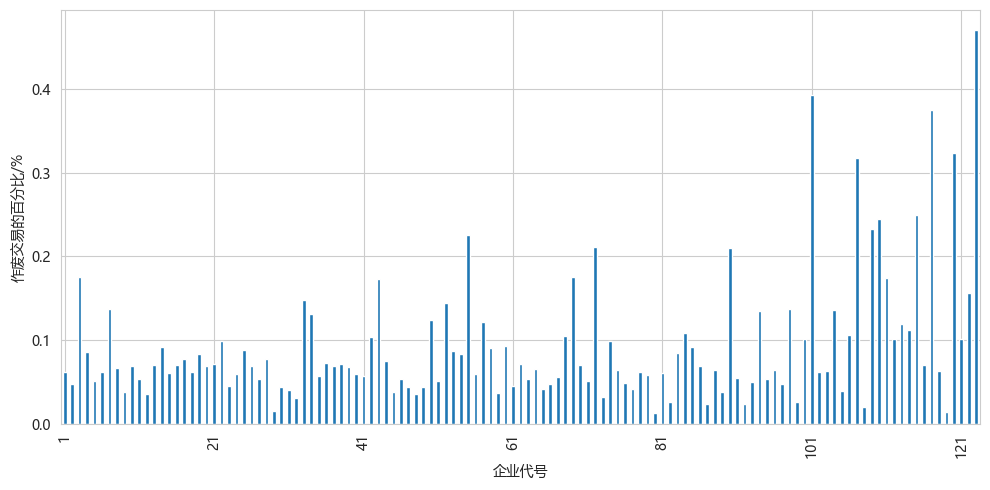

In [15]:
# 条形图
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)
rate_date.plot.bar()
ax.xaxis.set_major_locator(MultipleLocator(20))
ax.set_ylabel('作废交易的百分比/%')
plt.show()

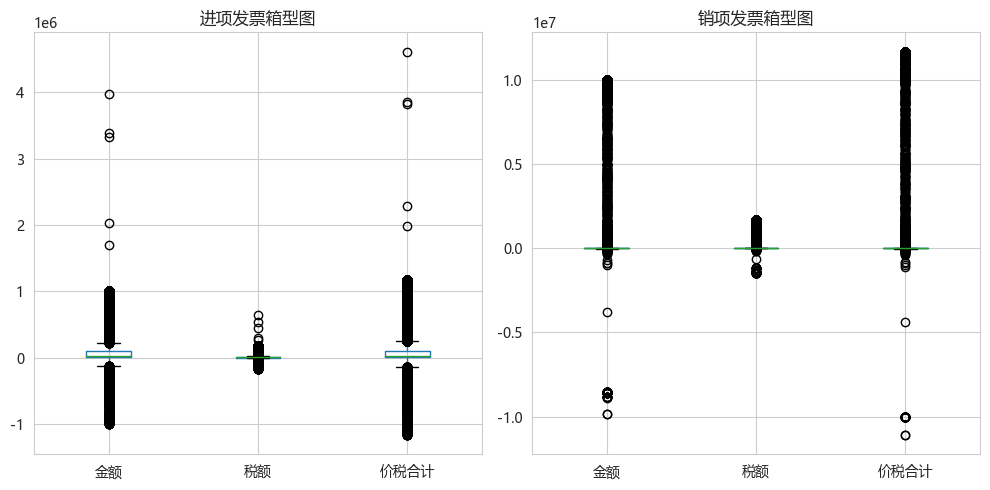

In [16]:
# 删除异常数据前的箱型图
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
BillImportData.boxplot(column=['金额', '税额', '价税合计'], ax=ax1)
ax1.set_title('进项发票箱型图')
BillOutportData.boxplot(column=['金额', '税额', '价税合计'], ax= ax2)
ax2.set_title('销项发票箱型图')
plt.show()

In [17]:
# import_std = BillImportData.loc[:, ['金额', '税额', '价税合计']].std()
# new_BillImportData = BillImportData.loc[(abs(BillImportData['金额']) < 4*import_std['金额'])&
#                    (abs(BillImportData['税额']) < 4*import_std['税额'])&
#                    (abs(BillImportData['价税合计']) < 4*import_std['价税合计'])]
# outport_std = BillOutportData.loc[:, ['金额', '税额', '价税合计']].std()
# new_BillOutportData = BillOutportData.loc[(abs(BillOutportData['金额']) < 4*import_std['金额'])&
#                                       (abs(BillOutportData['税额']) < 4*import_std['税额'])&
#                                       (abs(BillOutportData['价税合计']) < 4*import_std['价税合计'])]
cut_BillImportData = BillImportData.loc[BillImportData['发票状态'] > -1]
cut_BillOutportData = BillOutportData.loc[BillOutportData['发票状态'] > -1]

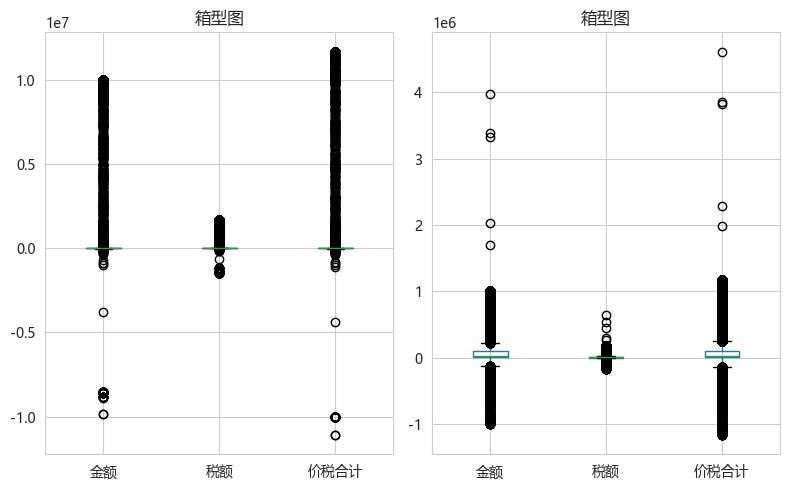

In [18]:
# 删除异常数据后的箱型图
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(8, 5), tight_layout=True)
cut_BillOutportData.boxplot(column=['金额', '税额', '价税合计'], ax = ax1)
ax1.set_title('箱型图')
cut_BillImportData.boxplot(column=['金额', '税额', '价税合计'], ax = ax2)
ax2.set_title('箱型图')
plt.show()

In [19]:
# 企业流水量

# 销项
import_acount = cut_BillImportData.groupby('企业代号')['价税合计'].sum()
# 进项
outport_acount = cut_BillOutportData.groupby('企业代号')['价税合计'].sum()


coo_floot_acount = (import_acount + outport_acount) / 10000

In [20]:
import_year_acount = cut_BillImportData.groupby(['企业代号', 'year'])['价税合计'].sum()
outport_year_acount = cut_BillOutportData.groupby(['企业代号', 'year'])['价税合计'].sum()

In [21]:
# 企业年平均毛利润
lirun = (import_year_acount - outport_year_acount).groupby('企业代号').mean()

lirun

企业代号
1     -4.848308e+08
2      9.137705e+07
3      1.504348e+08
4      6.306574e+08
5      1.535749e+06
           ...     
119   -6.403791e+04
120    4.871683e+04
121   -5.689162e+05
122    1.748585e+03
123    7.557323e+04
Name: 价税合计, Length: 123, dtype: float64

In [22]:
# 企业年平均毛利润率
lirun_rate = ((import_year_acount - outport_year_acount) / import_acount).groupby('企业代号').mean()
lirun_rate

企业代号
1     -0.103186
2      0.173064
3      0.229350
4      0.293802
5      0.006583
         ...   
119   -1.742907
120    0.248057
121   -4.977936
122    0.028788
123    0.332103
Name: 价税合计, Length: 123, dtype: float64

In [23]:
# 年上下游合作企业数量，每年上下游企业合作稳定性，企业是否违约

import_cooperation = cut_BillImportData.drop_duplicates(['购方单位代号', 'year', '企业代号']).groupby(['企业代号', cut_BillImportData['开票日期'].dt.year])['购方单位代号'].count()
# import_cooperation = cut_BillImportData.drop_duplicates(['销方单位代号', 'year']).groupby('企业代号')['销方单位代号'].count()

outport_cooperation = cut_BillOutportData.drop_duplicates(['销方单位代号', 'year', '企业代号']).groupby(['企业代号',
                                                                                        cut_BillOutportData['开票日期'].dt.year])['销方单位代号'].count()
# outport_cooperation = cut_BillOutportData.drop_duplicates(['购方单位代号', 'year']).groupby('企业代号')['购方单位代号'].count()
import_cooperation_num = import_cooperation.groupby('企业代号').mean()
outport_cooperation_num = outport_cooperation.groupby('企业代号').mean()

In [24]:
# 每年上下游企业合作稳定性
import_coo = cut_BillImportData.drop_duplicates(['购方单位代号', 'year', '企业代号'])
outport_coo = cut_BillOutportData.drop_duplicates(['销方单位代号', 'year', '企业代号'])

In [25]:
def in_out_computer(coo, nkey):
    cooperate_stable = pd.DataFrame({'企业代号':[], 'year': [], 'sheqi': [], 'xinzeng': []})
    item = coo.drop_duplicates(['企业代号', 'year'])[['企业代号', 'year']]
    for i in item.index:
        company = item['企业代号'].get(i)
        year = item['year'].get(i)
        if coo.loc[(coo['企业代号'] == company)&(coo['year'] == year + 1)].count()['企业代号'] != 0:
            alls = coo.loc[(coo['企业代号'] == company)&((coo['year'] == year)|(coo['year'] == year +
                                                                                        1))]
    #         cur.drop_duplicates('销方单位代号', keep=False)
            difference = alls.count()['企业代号'] - alls.drop_duplicates(nkey, keep=False).count()['企业代号']
            pre_num = alls.loc[alls['year'] == year].count()['企业代号']
            bac_num = alls.loc[alls['year'] == year + 1].count()['企业代号']
            sheqi = pre_num - difference
            xinzeng = bac_num - difference
            cooperate_stable.loc[len(cooperate_stable.index)] = [company, year + 1, sheqi, xinzeng]
    return cooperate_stable.groupby('企业代号')['sheqi'].mean(), cooperate_stable.groupby('企业代号')['xinzeng'].mean()

import_coo_sheqi, import_coo_xinzeng = in_out_computer(import_coo, '购方单位代号')
outport_coo_sheqi, outport_coo_xinzeng = in_out_computer(outport_coo, '销方单位代号')

In [26]:
# 企业是否违约
CompanyInfoData.loc[:, '企业代号'] = CompanyInfoData['企业代号'].str.replace('E', '')
CompanyInfoData.loc[:, '企业代号'] = CompanyInfoData['企业代号'].astype(dtype='int')
company_default = CompanyInfoData.loc[:, ['企业代号', '是否违约']]

C:\Users\pc\AppData\Local\Temp\ipykernel_13684\220882350.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  CompanyInfoData.loc[:, '企业代号'] = CompanyInfoData['企业代号'].astype(dtype='int')


In [27]:
# 企业信誉评级
company_score = CompanyInfoData.loc[:, ['企业代号', '信誉评级']]
company_score.loc[:, '信誉评级'] = company_score['信誉评级'].str.replace('A', '1')
company_score.loc[:, '信誉评级'] = company_score['信誉评级'].str.replace('B', '0.75')
company_score.loc[:, '信誉评级'] = company_score['信誉评级'].str.replace('C', '0.5')
company_score.loc[:, '信誉评级'] = company_score['信誉评级'].str.replace('D', '0.25')
company_score['信誉评级'].astype(dtype='float')
# company_score = pd.DataFrame(company_score.get('信誉评级'), index=np.arange(1, 124))
company_score.index = np.arange(1, 124)


In [28]:
# 企业总流水量
# coo_floot_acount

In [29]:
# 企业年毛利润
# lirun

In [30]:
# 上游年平均合作企业数量
check_nan(import_cooperation_num)
import_cooperation_num

企业代号
1      179.500000
2      554.500000
3       68.750000
4       12.000000
5       13.000000
          ...    
119      5.666667
120      2.000000
121     61.000000
122     17.750000
123      2.666667
Name: 购方单位代号, Length: 123, dtype: float64

In [31]:
# 下游年平均合作企业数量
check_nan(outport_cooperation_num)
outport_cooperation_num

企业代号
1       143.250000
2      1337.750000
3       215.250000
4        46.000000
5       121.000000
          ...     
119       8.250000
120       6.333333
121       5.666667
122       6.750000
123       1.000000
Name: 销方单位代号, Length: 123, dtype: float64

In [32]:
# 上游平均企业新增数量，上游平均企业终止数量
#import_coo_sheqi, import_coo_xinzeng
check_nan(import_coo_sheqi, 0)
check_nan(import_coo_xinzeng, 0)
check_nan(outport_coo_sheqi, 0)
check_nan(outport_coo_xinzeng, 0)


In [33]:
df = pd.DataFrame([coo_floot_acount, lirun, lirun_rate, import_rate, outport_cooperation_num+import_cooperation_num,
                   import_coo_sheqi, import_coo_xinzeng, np.ones(124), company_score['信誉评级'].astype(dtype='float'),
                   pd.DataFrame([company_default['是否违约']]).T.set_index(np.arange(1, 124)).get('是否违约')]).T
columns = ['企业总流水量', '企业年平均毛利润', '企业年平均利润率','企业销项销售违约率','年平均合作企业数量',
           '下游平均企业新增数量', '下游平均企业终止数量', 'b', '信誉评级', '是否违约']
df.columns=columns

In [34]:
logit = sm.Logit(df['是否违约'], df.iloc[:, :-1])
res = logit.fit()

Optimization terminated successfully.
         Current function value: 0.112277
         Iterations 13


In [35]:
print(res.predict(df.iloc[:, :-1]) > 0.5 )

1      False
2      False
3      False
4      False
5      False
       ...  
119     True
120     True
121     True
122     True
123     True
Length: 123, dtype: bool


In [36]:
wd_probs = res.pred_table()
pd.DataFrame(wd_probs, columns=['1', '0'], index=['1', '0'])

,1,0
1,96.0,0.0
0,3.0,24.0


In [37]:
print(res.summary())


                           Logit Regression Results                           
Dep. Variable:                   是否违约   No. Observations:                  123
Model:                          Logit   Df Residuals:                      114
Method:                           MLE   Df Model:                            8
Date:                Sun, 02 Jul 2023   Pseudo R-squ.:                  0.7867
Time:                        16:47:14   Log-Likelihood:                -13.810
converged:                       True   LL-Null:                       -64.734
Covariance Type:            nonrobust   LLR p-value:                 1.789e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
企业总流水量        -0.0001      0.000     -0.463      0.643      -0.001       0.000
企业年平均毛利润    4.412e-08   1.06e-07      0.418      0.676   -1.63e-07    2.51e-07
企业年平均利润率      -1.3732      2.313     -0.594      0.5

In [38]:
wd_probs

array([[96.,  0.],
       [ 3., 24.]])

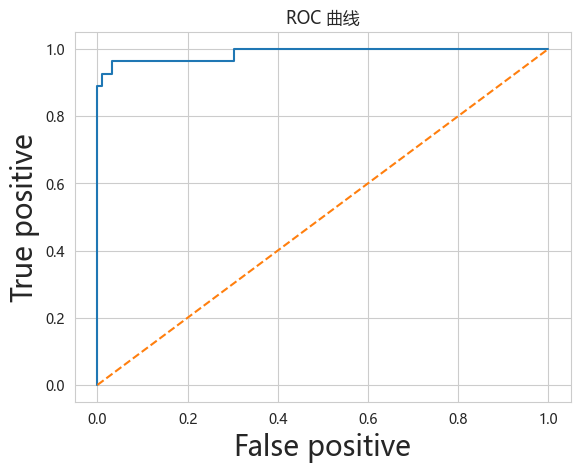

In [39]:
resu = res.predict(df.iloc[:, :-1])
fpr, tpr, threshold = roc_curve(df['是否违约'], resu)
#ROC曲线
plt.plot(fpr, tpr)
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel('False positive', fontsize=20)
plt.ylabel('True positive', fontsize=20)
plt.title('ROC 曲线')

plt.show()
